<center><b>EE 538 Spring 2021<br>
Low-Noise Analog Circuit Design<br>
University of Washington Electrical & Computer Engineering</b></center>


<b>Instructor: Jason Silver<br>
Assignment #1 (10 points)<br>
Due Sunday, April 11 (Submit on Canvas as a Jupyter Notebook)</b> 

*Please show your work*

Resources: 

https://analog.intgckts.com/equivalent-noise-bandwidth/#:~:text=Equivalent%20Noise%20Bandwidth%201%20comment&text=Equivalent%20noise%20bandwidth(ENBW)%20is,bandwidth%20or%20effective%20noise%20bandwidth.&text=or%20magnitude%20of%20brickwall%20filter%20in%20passband

http://www.onmyphd.com/?p=enbw.equivalent.noise.bandwidth

https://www.k-state.edu/edl/docs/pubs/technical-resources/Technote1.pdf

http://web.engr.oregonstate.edu/~webbky/ENGR202_files/SECTION%203%20Second%20Order%20Filters.pdf

https://www.ti.com/lit/an/sloa049b/sloa049b.pdf?ts=1617717745044&ref_url=https%253A%252F%252Fwww.google.com%252F

In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<b>Problem 1: Noise bandwidth

The transfer function of a second-order low-pass filter can be written as

\begin{equation}
H(s)={\frac {\omega _{0}^{2}}{s^{2}+2\zeta \omega _{0}\cdot s+\omega _{0}^{2}}}
\end{equation}

where $\omega_0$ is the resonant frequency and $\zeta$ is the damping factor.

<u>*Analysis*</u>

__a)__ Derive a general expression for the noise bandwidth of a second-order low-pass filter.

$\begin{eqnarray}
H(s)  &=& {\frac {\omega _{0}^{2}}{s^{2}+2\zeta \omega _{0}\cdot s+\omega _{0}^{2}}} \\[2pt]
      &=& {\frac {\omega _{0}^{2}}{s^{2}+\frac{s\cdot\omega_0}{Q}+\omega _{0}^{2}}} \\[2pt]
      &=& {\frac {1}{\frac{s^{2}}{\omega_0^2}+\frac{s}{Q\omega_0}+1}} \\[2pt]
      &=& {\frac {1}{\frac{(j\omega)^{2}}{\omega_0^2}+\frac{(j\omega)}{Q\omega_0}+1}} \\[2pt]
      &=& {\frac {1}{\frac{-\omega^2}{\omega_0^2}+\frac{j\omega}{Q\omega_0}+1}} \\[3pt]
|H(s)|&=& {\frac {1}{\sqrt{(1+\frac{-\omega^2}{\omega_0^2})^2+(\frac{\omega}{Q\omega_0})^2}}} &\text{and Butterworth }& Q=\frac{1}{\sqrt2} \\[2pt]
      &=& {\frac {1}{\sqrt{1-\frac{2\omega^2}{\omega_0^2}+\frac{\omega^4}{\omega_0^4}+\frac{\omega^2}{Q^2\omega_0^2}}}} \\[2pt]
      &=& {\frac {1}{\sqrt{1-\frac{2\omega^2}{\omega_0^2}+\frac{\omega^4}{\omega_0^4}+\frac{2\omega^2}{\omega_0^2}}}} \\[2pt]
      &=& {\frac {1}{\sqrt{1+\frac{\omega^4}{\omega_0^4}}}} \\[2pt]
      &=& {\frac {1}{\sqrt{1+(\frac{\omega}{\omega_0})^4}}} &\text{and Butterworth }& \omega_0 = \omega_c \\[2pt]
      &=& {\frac {1}{\sqrt{1+(\frac{\omega}{\omega_c})^4}}} \\[3pt]
\omega_{enb} &=& \int_{0}^\infty \displaystyle\left\lvert{H(s)}\right\rvert^2\ d\omega \\[2pt]
  &=& \int_{0}^\infty \frac{1}{1+(\frac{\omega}{\omega_c})^4}\ d\omega \\[3pt]
f_{enb} &=& \frac{1}{2\pi} \int_{0}^\infty \frac{1}{1+(\frac{\omega}{\omega_c})^4}\ d\omega
\end{eqnarray}$

__b)__ Using your expression from part __a__, determine the relationship between the noise bandwidth and the $-3\text{dB}$ bandwidth of a second-order Butterworth filter.

$\begin{eqnarray}
f_{enb} &=& \frac{1}{2\pi} \int_{0}^\infty \frac{1}{1+(\frac{\omega}{\omega_{c}})^4}\ d\omega \\[3pt]
        && \text{let } x=\frac{\omega^4}{{\omega_c}^4} \\[3pt]
        &=& \frac{1}{2\pi} \int_{0}^\infty \frac{1}{1+x^4} dx \cdot \omega_c  \\[3pt]
        &=& \frac{\omega_c}{2\pi} \cdot \frac{\pi}{2\sqrt{2}} \\[3pt]
        &=& \frac{2\pi f_c}{2\pi} \cdot \frac{\pi}{2\sqrt{2}} \\[3pt]
        &=& \frac{\pi}{2\sqrt{2}} f_c \\[3pt]
        &\approx& 1.11 f_c
\end{eqnarray}$

<u>*Design*</u>

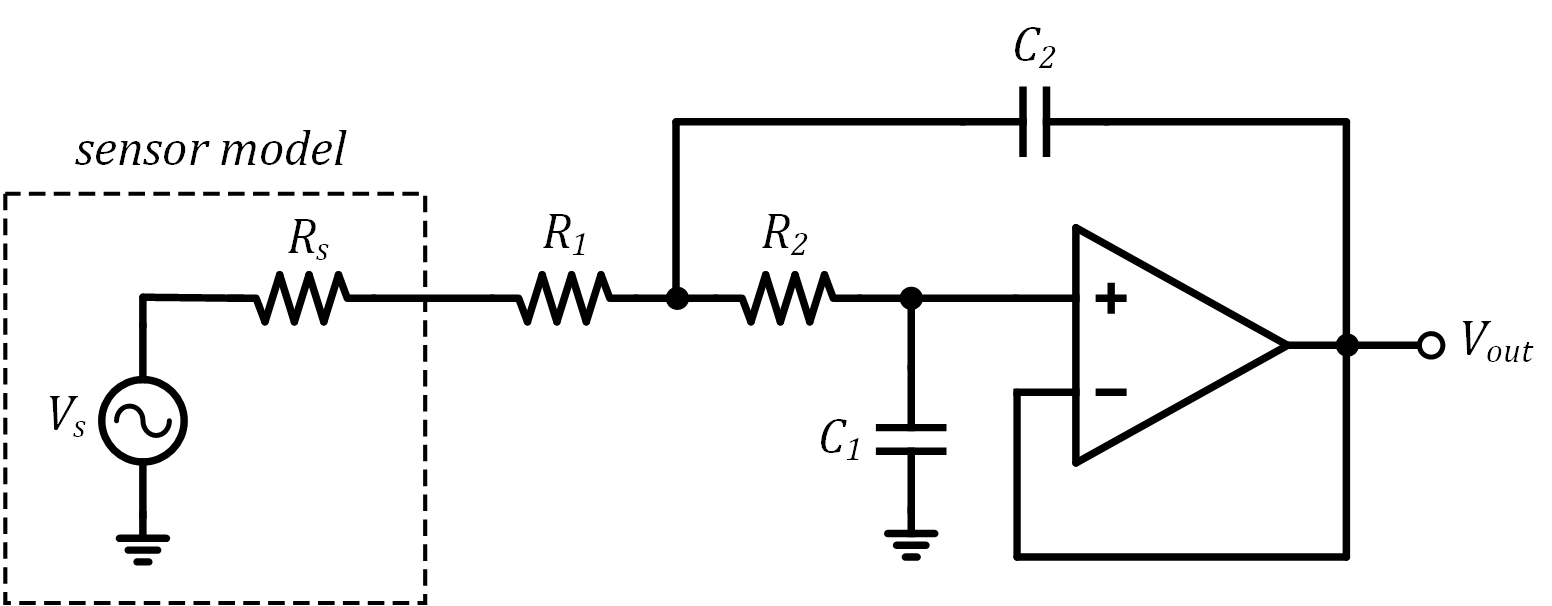

__c)__ Using the Sallen-Key structure shown above, design an active second-order Butterworth filter (i.e. determine $R$ and $C$ values) to limit the noise bandwidth of a resistive sensor with equivalent resistance $R_s = 1\text{k}\Omega$. Design the filter to achieve an input-referred $rms$ noise of $40\text{nV}$. Assume that the opamp and filter resistors are noiseless.

$\begin{eqnarray}
T &=& 25C = 298 K \\
k &=& 1.381 \cdot 10^{−23} \\
R_s &=& 1000
\end{eqnarray}$

$\begin{eqnarray}
v_{n,in(\text{rms})} &=& \sqrt{v_{n,in}^2 \cdot f_{enb}} \\[3pt]
40 \text{nV}  &\geq& \sqrt{e_n^2 \cdot f_{enb}}  \\[3pt]
e_n^2 \text{ } &=& {4kTR_{s}} \\[3pt]
 &=& 1.6458 \cdot 10^{-17} \frac{V^2}{\text{Hz}} \\[3pt]
40 \text{nV}  &\geq& \sqrt{1.6458 \cdot 10^{-17} \cdot f_{enb}}  \\[3pt]
40 \text{nV}  &\geq& \sqrt{1.6458 \cdot 10^{-17} \cdot 1.11 f_{c}}  \\[3pt]
f_c &\leq& \frac{(40 \text{nV})^2}{1.6458 \cdot 10^{-17} \cdot 1.11} \\[3pt]
f_c &\leq& 87.6 \text{Hz}
\end{eqnarray}$

In [2]:
T = 298
k = 1.381 * 1e-23
Rs= 1000
target = 40*1e-9
Vrms = np.sqrt(4*k*T*Rs*1.11)
fc = target**2/Vrms**2
fenb = 1.11*fc
print(f'fc: {round(fc,4)}, and f_enb: {round(fenb,4)}')

fc: 87.5643, and f_enb: 97.1964


In [3]:
s,m,n,C1,C2,R1,R2,Q,tau,W0,Wc,Cn,K = sp.symbols('s,m,n,C1,C2,R1,R2,Q,tau,omega0,Wc,Cn,K')

In [4]:
# Low Pass Butterworth
fc1 = 87.56
systemLP = sp.Matrix([
    [W0 - 1/(tau*sp.sqrt(m*n))],
    [W0 - Cn*Wc],
    [Q - sp.sqrt(m*n)/(1+m)],
    [m - R1/R2],
    [n - C1/C2],
    [tau - R2*C2]
])
myVals = {
    W0:2*np.pi*fc1,  # Cutoff Frequency in radians/s
    Cn:1,            # Table 
    Q:1/np.sqrt(2),  # Table 
    m:1,             # Chosen Ratio
    C2:10e-9         # Chosen Value 
}
systemLP = systemLP.subs(myVals)
eq = sp.solve(systemLP)
eq, myVals

({C1: 2.00000000000000e-8,
  R1: 128528.482777111,
  R2: 128528.482777111,
  n: 2.00000000000000,
  tau: 0.00128528482777111,
  Wc: 550.155705496645},
 {omega0: 550.1557054966446, Cn: 1, Q: 0.7071067811865475, m: 1, C2: 1e-08})

In [9]:
f = np.logspace(-2, 4, 10000)
w = 2*np.pi*f
#s = 1j*w

num = W0**2
den = s**2 + s*W0/Q + W0**2

components = {
    #C1:2e-8,
    #C2:1e-8,
    #R1:128528,
    #R2:128528,
    W0:550.16,
    Q :1/np.sqrt(2)    
}
H = sp.Matrix([num/den])
H1 = H = H.subs(components)
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]

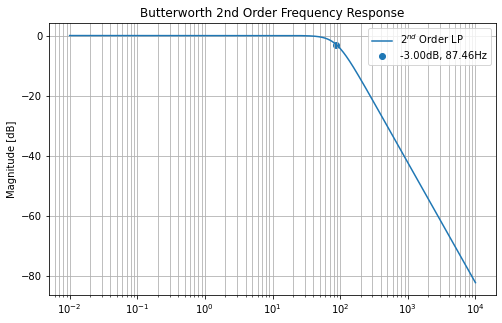

In [15]:
fig, ax = plt.subplots(figsize=(8,5))

x1 = np.where(20*np.log10(abs(H))<=-3)[0][0]
label1 = "{:.2f}dB, {:.2f}Hz".format(20*np.log10(abs(H[x1])),f[x1])

ax.set_title('Butterworth 2nd Order Frequency Response')
ax.semilogx(f, 20*np.log10(abs(H)),label=r'$2^{nd}$ Order LP')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

__d)__ Verify your design in Ltspice using the *UniversalOpamp2* model with a bandwidth of $10\text{MHz}$. Demonstrate the frequency response and noise performance over a frequency range of $100\text{MHz}$, and verify that the $rms$ noise meets the specification by integrating over the full $100\text{MHz}$ range.

__e)__ If the sensor exhibits $1/f$ noise, the spectral density of the noise can be expressed as

\begin{equation}
\overline{e_n^2} = 4kTR_s\cdot\left(1+\dfrac{f_c}{f}\right)\Delta f
\end{equation}

where $f_c$ is the $1/f$ noise corner frequency. Determine the $rms$ noise (at the output of the filter) between $1\text{Hz}$ and $1\text{MHz}$ if $f_c = 1\text{kHz}$.  Verify this in Ltspice. Explain why the concept of noise bandwidth doesn't apply to noise processes that aren't white.

*Use the expression 'noiseless' after the resistance value in Ltspice to prevent specific resistors from generating noise during noise analysis.* 

*To avoid loading between the sensor and filter input, you can use the 'E' component in Ltspice (voltage-controlled voltage source).* 